In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

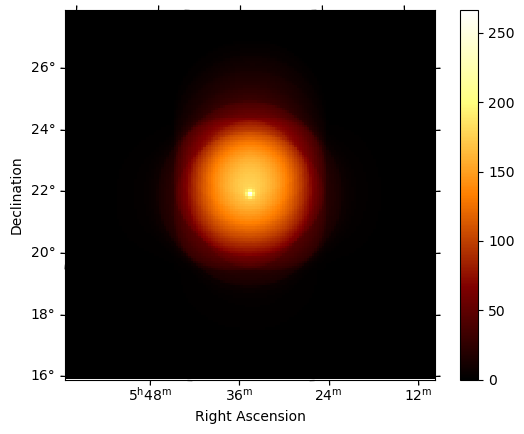

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Single Cases and Correlation

In [4]:
factors = np.array([0.10, -0.085, 0.03])
rnd = False
sys = sys_dataset(dataset_asimov, factors[0], 1e-24, rnd)
dataset_input = sys.create_dataset()
tilt_neg = 1e-24

factor 1 = 0.1
factor 2 = -0.085
factor 3 = 0.03
CPU times: total: 9.28 s
Wall time: 9.36 s


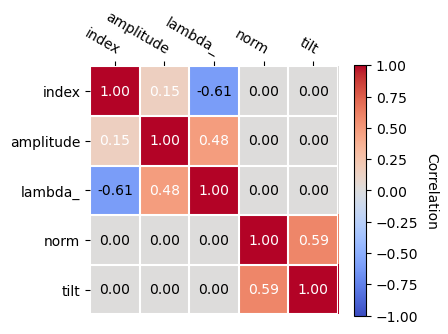

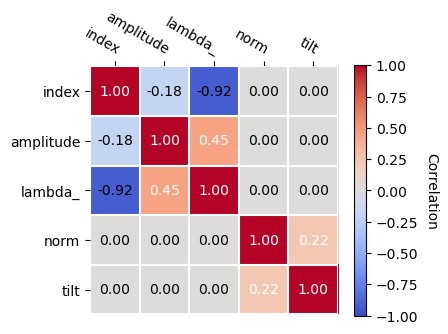

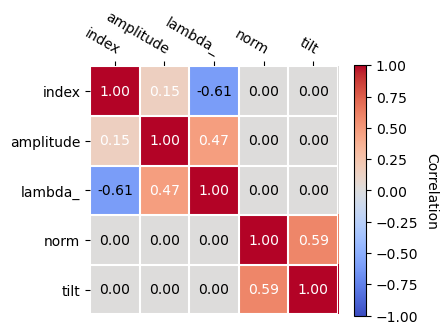

In [5]:
%%time
for i, factor in enumerate(factors):
    print('factor', i+1, '=', factor)
    
    sys = sys_dataset(dataset_asimov, factor, tilt_neg, rnd)
    dataset = sys.create_dataset()
    datasets = Datasets(dataset)
    
    fit = Fit(store_trace=False)
    result = fit.run(datasets)
    
    datasets.models.covariance.get_subcovariance(datasets.models.parameters.free_parameters).plot_correlation()  

shift 1 = 0.1
shift 2 = -0.085
shift 3 = 0.03
CPU times: total: 21min 38s
Wall time: 2min 59s


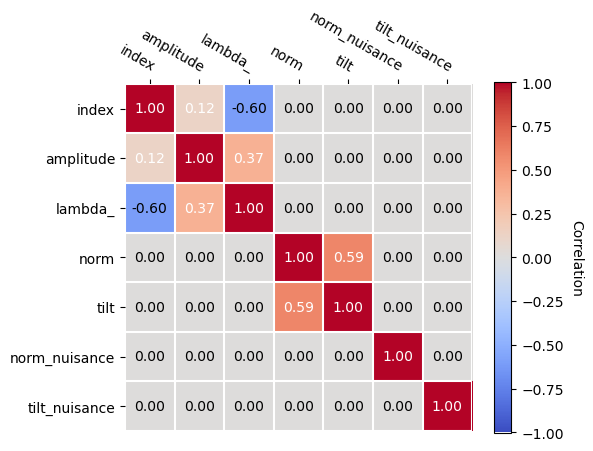

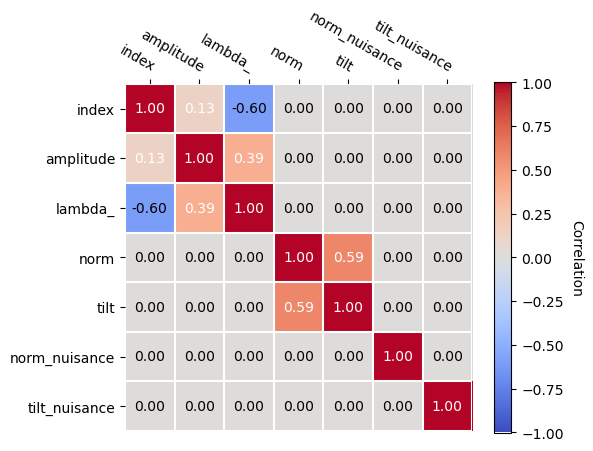

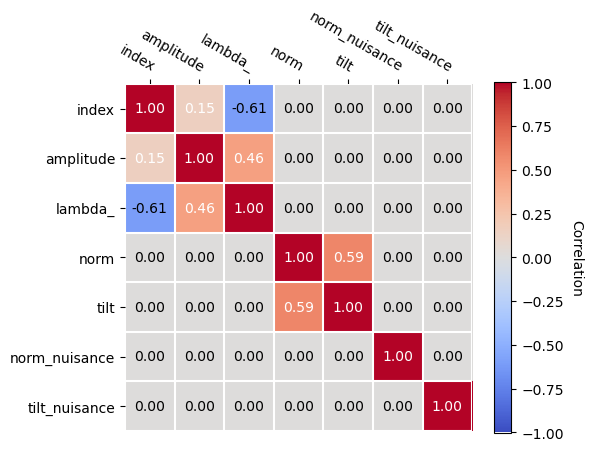

In [7]:
%%time
for i, factor in enumerate(factors):
    print('shift', i+1, '=', factor)
    
    sys = sys_dataset(dataset_asimov, factor, tilt_neg, rnd)
    dataset_N = sys.create_dataset_N()
    
    zero = 1e-24
    ## additional parameter bias and resolution (ereco) but are frozen
    penalising_invcovmatrix = np.zeros((4, 4))
    np.fill_diagonal(penalising_invcovmatrix,
                     [1/factor**2, 1/tilt_neg**2, 1/zero**2, 1/zero**2])

    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    datasets_N = Datasets(dataset_N)
    
    fit = Fit(store_trace=False)
    result = fit.run(datasets_N)
    
    datasets_N.models.covariance.get_subcovariance(datasets_N.models.parameters.free_parameters).plot_correlation()